# AMV Historical Data

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [2]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('AMV Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [3]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,3700.0,3600.0,3800.0,3600.0,1440000,0.0278
1,05/30/2024,3600.0,3600.0,3800.0,3500.0,3230000,0.0286
2,05/29/2024,3500.0,3500.0,3600.0,3500.0,522679,0.0000
3,05/28/2024,3500.0,3500.0,3600.0,3500.0,452540,0.0000
4,05/27/2024,3500.0,3500.0,3600.0,3500.0,660470,0.0000
...,...,...,...,...,...,...,...
1308,03/07/2019,14144.0,14594.0,14594.0,14144.0,28810,-0.0308
1309,03/06/2019,14594.0,14414.0,14684.0,14414.0,17250,0.0125
1310,03/05/2019,14414.0,14865.0,15045.0,14414.0,48800,-0.0303
1311,03/04/2019,14865.0,15180.0,15180.0,14865.0,19010,-0.0236


In [4]:
df1

0        3700.0
1        3600.0
2        3500.0
3        3500.0
4        3500.0
         ...   
1308    14144.0
1309    14594.0
1310    14414.0
1311    14865.0
1312    15225.0
Name: Price, Length: 1313, dtype: float64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0658 - val_loss: 0.0239
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0105 - val_loss: 0.0045
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

In [12]:
# 10. Dự báo dữ liệu test và chuẩn hoá và chuẩn hoá
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [13]:
# 11. Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 791.26105
MAPE trên tập test là: 3.63149531185627 %
MSLE trên tập test là: 0.002671944


In [14]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.59054995]
335
1 day input [0.76796564 0.79962538 0.81017863 0.81017863 0.82598565 0.84709215
 0.81543241 0.77321943 0.7574124  0.76271186 0.72575266 0.80487916
 0.78377267 0.87345242 0.88925945 0.91561972 0.8787062  0.79962538
 0.78907214 0.76271186 0.77851889 0.7574124  0.76271186 0.76271186
 0.79432592 0.77851889 0.77851889 0.75215862 0.75215862 0.75215862
 0.7574124  0.76271186 0.76796564 0.77851889 0.77321943 0.7574124
 0.7574124  0.76271186 0.7574124  0.74160537 0.7574124  0.76271186
 0.70994563 0.69939239 0.72049888 0.72575266 0.72575266 0.69939239
 0.74160537 0.70994563 0.70469185 0.65722509 0.58865183 0.58865183
 0.58335237 0.58865183 0.57809859 0.59390561 0.58865183 0.5358856
 0.48316506 0.45150532 0.44625154 0.50427155 0.52007858 0.5358856
 0.48316506 0.50427155 0.57284481 0.58865183 0.60445886 0.57809859
 0.56229156 0.59390561 0.67303212 0.7574124  0.77851889 0.3834346
 0.43807392 0.45625657 0.46539358 0.46233268 0.44415003 0.44108913
 0.39860204 0.39257161 0.40773905 0.3

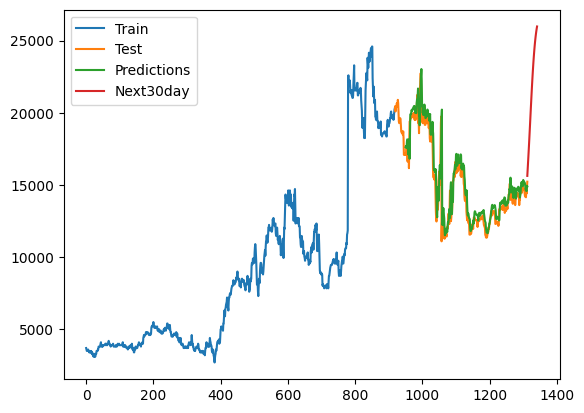

In [15]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DHT Historical Data

In [16]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('DHT Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [17]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,40400.0,39300.0,41000.0,38900.0,154530,0.0280
1,05/30/2024,39300.0,38800.0,39800.0,38500.0,76570,-0.0051
2,05/29/2024,39500.0,39900.0,39900.0,38300.0,107350,0.0051
3,05/28/2024,39300.0,38600.0,39500.0,38200.0,61630,0.0181
4,05/27/2024,38600.0,35200.0,39900.0,35200.0,133260,0.0604
...,...,...,...,...,...,...,...
1307,03/07/2019,11589.7,11842.2,11842.2,11224.9,240150,0.0024
1308,03/06/2019,11561.6,11309.1,11589.7,11309.1,292910,0.0198
1309,03/05/2019,11337.1,11224.9,11365.2,10888.1,308000,0.0100
1310,03/04/2019,11224.9,11056.5,11477.4,11056.5,296000,0.0336


In [18]:
df1

0       40400.0
1       39300.0
2       39500.0
3       39300.0
4       38600.0
         ...   
1307    11589.7
1308    11561.6
1309    11337.1
1310    11224.9
1311    10860.1
Name: Price, Length: 1312, dtype: float64

In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [20]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [21]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [23]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0428 - val_loss: 0.0020
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0010 - val_loss: 9.1182e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 8.9905e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0010 - val_loss: 8.6616e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0010 - val_loss: 8.2331e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.1361e-04 - val_loss: 7.0972e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.7195e-04 - val_loss: 7.9686e-04
Epoch 12/100
14/14 ━

In [26]:
# 10. Dự báo dữ liệu test và chuẩn hoá
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [27]:
# 11. Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 539.24426
MAPE trên tập test là: 2.5613075122237206 %
MSLE trên tập test là: 0.0013207144


In [28]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.06280186]
335
1 day input [0.18638122 0.19499613 0.1809969  0.17992004 0.1842275  0.18207377
 0.18961181 0.18745809 0.18961181 0.18745809 0.1928424  0.19391927
 0.18530436 0.21222917 0.18745809 0.18207377 0.17668945 0.17345886
 0.17992004 0.17992004 0.18207377 0.18207377 0.17884318 0.18207377
 0.18207377 0.18207377 0.18530436 0.19068868 0.1928424  0.19499613
 0.19822672 0.20038045 0.19930359 0.18853495 0.19930359 0.19714986
 0.1928424  0.18853495 0.18207377 0.1928424  0.19391927 0.19499613
 0.19068868 0.19068868 0.20361104 0.21545976 0.21123936 0.20912755
 0.23550426 0.21756835 0.20385285 0.20912755 0.18908305 0.19330346
 0.19013735 0.19013735 0.18275406 0.18064225 0.17747937 0.16376386
 0.16165205 0.16165205 0.16165205 0.14582796 0.17009286 0.16903856
 0.16165205 0.16165205 0.18169654 0.18275406 0.18486265 0.18380836
 0.18275406 0.18275406 0.18275406 0.19752386 0.19752386 0.20068997
 0.20807325 0.20596466 0.20385285 0.20385285 0.19330346 0.19224916
 0.18275406 0.19119487 0.19752386

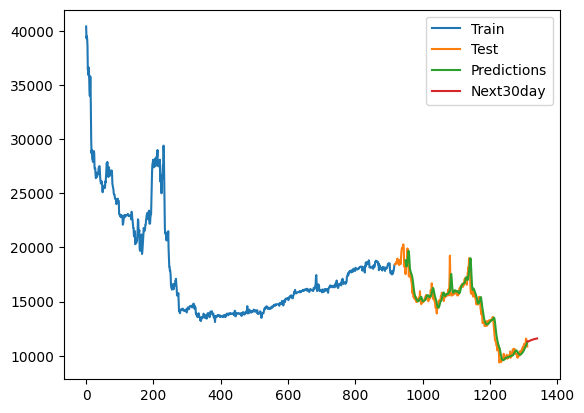

In [29]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DP3 Historical Data

In [33]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('DP3 Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [38]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,61600.0,61500.0,61700.0,61500.0,10.51K,0.0016
1,05/30/2024,61500.0,61000.0,61500.0,60700.0,5.11K,0.0082
2,05/29/2024,61000.0,62000.0,62000.0,61000.0,7.30K,0.0000
3,05/28/2024,61000.0,61000.0,61800.0,60900.0,7.90K,0.0016
4,05/27/2024,60900.0,61700.0,61700.0,60900.0,12.67K,-0.0016
...,...,...,...,...,...,...,...
1132,03/07/2019,76300.0,75000.0,76900.0,74700.0,11.57K,0.0214
1133,03/06/2019,74700.0,74100.0,75000.0,74000.0,3.81K,0.0040
1134,03/05/2019,74400.0,75000.0,75000.0,74000.0,7.33K,-0.0067
1135,03/04/2019,74900.0,73800.0,75200.0,73800.0,8.34K,0.0149


In [39]:
df1

array([[0.25957666],
       [0.25871968],
       [0.25443483],
       ...,
       [0.369269  ],
       [0.37355386],
       [0.36412717]])

In [34]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [35]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [36]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [37]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [40]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [41]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.1369 - val_loss: 0.0018
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0164 - val_loss: 0.0080
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0112 - val_loss: 0.0013
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046 - val_loss: 9.7500e-04
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0037 - val_loss: 9.8465e-04
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [43]:
# 10. Dự báo dữ liệu test và chuẩn hoá
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [44]:
# 11. Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 1861.6752
MAPE trên tập test là: 1.7839886248111725 %
MSLE trên tập test là: 0.0006848133


In [45]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.35977542]
283
1 day input [0.33070529 0.32384952 0.34013197 0.35555746 0.36584112 0.44296855
 0.45496615 0.44725341 0.42582912 0.42582912 0.43868369 0.44296855
 0.46267889 0.43782672 0.37441083 0.37441083 0.37012597 0.37012597
 0.3512726  0.3272774  0.3272774  0.33070529 0.30585312 0.32299254
 0.32299254 0.29299854 0.29299854 0.29042763 0.2972834  0.28871369
 0.29042763 0.28871369 0.28871369 0.28871369 0.28871369 0.28014397
 0.28014397 0.25357786 0.28014397 0.32299254 0.27157426 0.27157426
 0.27157426 0.26300454 0.28871369 0.28871369 0.26300454 0.28014397
 0.30585312 0.30585312 0.28871369 0.28785671 0.29299854 0.31870769
 0.32299254 0.33156226 0.34013197 0.3332762  0.34013197 0.34013197
 0.34013197 0.35384352 0.33584712 0.34013197 0.33584712 0.33156226
 0.37355386 0.37183992 0.37269689 0.37355386 0.34013197 0.34013197
 0.36584112 0.37441083 0.36584112 0.37441083 0.37441083 0.37441083
 0.37441083 0.34013197 0.37441083 0.36584112 0.36584112 0.34013197
 0.34013197 0.32299254 0.36584112

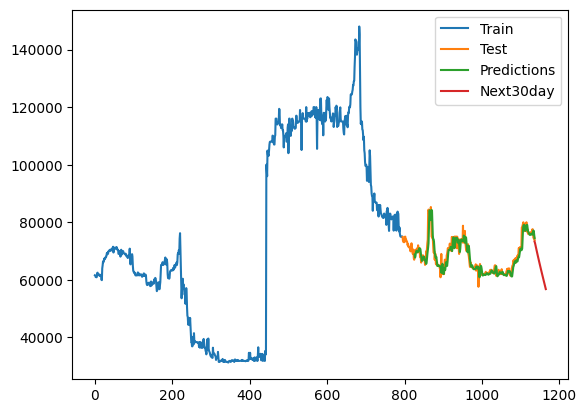

In [46]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()